# Wflow.jl in eWaterCycle

This notebook showcases the use of the Wflow.jl model in eWaterCycle.

To install Wflow.jl, uncomment this first block before running the rest of the code:

In [1]:
# from ewatercycle_wflowjl.model import install_wflow
# install_wflow()

In [2]:
from pathlib import Path
import ewatercycle
import numpy as np
from IPython.display import clear_output

from ewatercycle_wflowjl.forcing.forcing import WflowJlForcing
from ewatercycle_wflowjl.model import WflowJl
from ewatercycle_wflowjl.utils import get_geojson_locs

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
/home/bart/micromamba/envs/ewatercycle/lib/python3.10/site-packages/esmvalcore/experimental/_warnings.py:13: UserWarning: 
  Thank you for trying out the new ESMValCore API.
  Note that this API is experimental and may be subject to change.
  More info: https://github.com/ESMValGroup/ESMValCore/issues/498


In [3]:
from ewatercycle.base.parameter_set import ParameterSet

parameters_humber = ParameterSet(
    name="humber",
    directory=Path("/home/bart/wflow_humber"),
    target_model="WflowJl",
    config="wflow_sbm.toml"   
)

In [4]:
model = WflowJl(
    parameter_set=parameters_humber,
)

In [5]:
cfg_file,_ = model.setup()

In [6]:
model.initialize(cfg_file)

[ Info: Initialize model variables for model type `sbm`.
[ Info: Cyclic parameters are provided by `/home/bart/wflow_humber/staticmaps.nc`.
[ Info: Forcing parameters are provided by `/home/bart/wflow_humber/inmaps-era5-2013_xaver.nc`.
[ Info: Set `vertical.precipitation` using NetCDF variable `precip` as forcing parameter.
[ Info: Set `vertical.temperature` using NetCDF variable `temp` as forcing parameter.
[ Info: Set `vertical.potential_evaporation` using NetCDF variable `pet` as forcing parameter.
[ Info: Set `vertical.leaf_area_index` using NetCDF variable `LAI` as cyclic parameter.
┌ Info: General model settings
│   reservoirs = true
│   lakes = false
│   snow = true
│   masswasting = true
└   glacier = false
[ Info: Set `subcatchment` using NetCDF variable `wflow_subcatch`.
[ Info: Set `river_location` using NetCDF variable `wflow_river`.
[ Info: Set `lateral.river.width` using NetCDF variable `wflow_riverwidth`.
[ Info: Set `lateral.river.length` using NetCDF variable `wflow_ri

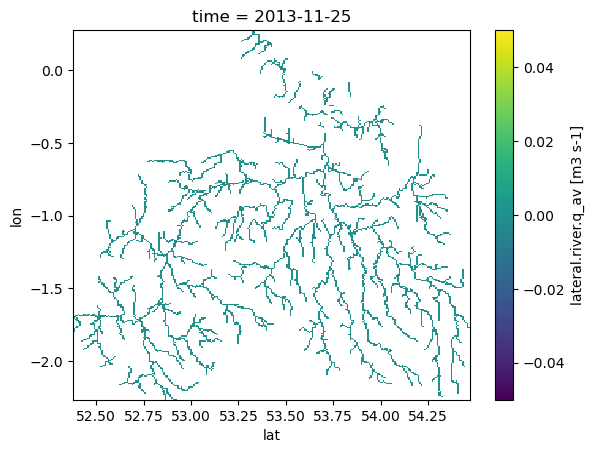

In [7]:
da = model.get_value_as_xarray("lateral.river.q_av")
da.unstack().isel(time=0).plot()

Text(0, 0.5, 'discharge [m3/s]')

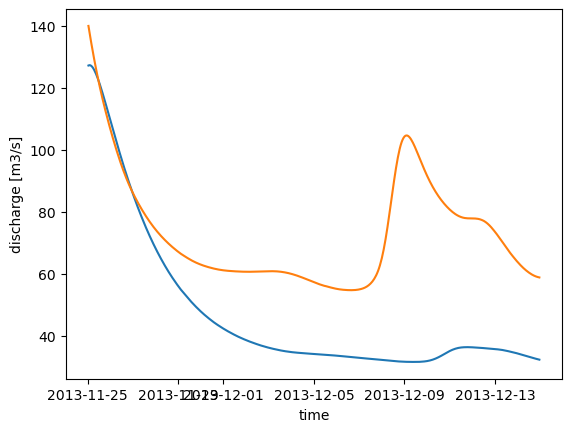

In [8]:
#      Location A, Location B.
lats = [53.274166, 53.765833,]
lons = [-0.761666, -0.986666,]

ntimesteps = int(model._bmi.get_end_time() / model._bmi.get_time_step()) - 1
q_locs = np.zeros((ntimesteps, 2,))
dtimes = []
for tstep in range(q_locs.shape[0]):
    model.update()
    q_locs[tstep] = model.get_value_at_coords("lateral.river.q_av", lats, lons)
    dtimes.append(model.time_as_datetime)

import matplotlib.pyplot as plt
plt.plot(dtimes, q_locs[:, 0])
plt.plot(dtimes, q_locs[:, 1])
plt.xlabel("time")
plt.ylabel("discharge [m3/s]")

We can load model coupling locations from a geojson file, and get the discharge at those locations:

In [9]:
lats, lons = get_geojson_locs("/home/bart/Downloads/gauges_src.geojson")

model.get_value_at_coords("lateral.river.q_av", lats, lons)

array([32.40296702, 58.92205788,  9.40452881,  9.14641328,  3.28022101,
        1.21642889,  1.95702639,  1.23389226,  0.77603632,  0.33483819,
        0.33075614,  0.24121365,  0.21427417,  0.10258944,  0.09825702,
        0.10319047,  0.30268187,  0.20068187,  0.26775474,  0.29128219,
        0.18014927,  0.18577489,  0.09252461,  0.09873827,  0.07020488])

As a validation of the locations we can plot them on the discharge map:

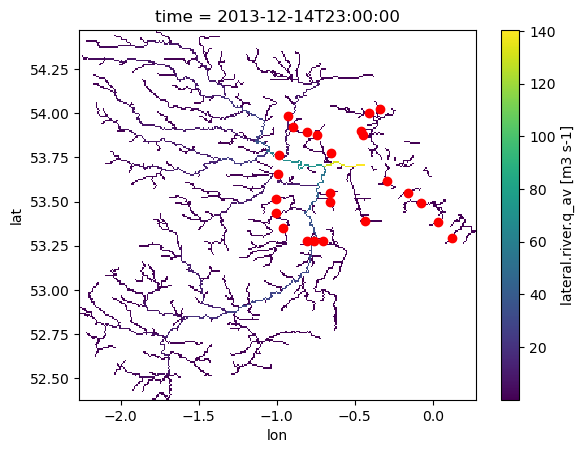

In [ ]:
da = model.get_value_as_xarray("lateral.river.q_av")
da.unstack().isel(time=0).plot(x="lon")
plt.scatter(lons, lats, marker="o", c="red")

In [ ]:
model.finalize()